<a href="https://colab.research.google.com/github/jay900411/DataAnalysis/blob/main/%E9%87%91%E5%B1%AC%E6%B0%A7%E5%8C%96%E7%89%A9%E8%88%87%E7%A9%BA%E6%B1%A1%E7%9B%B8%E9%97%9C%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 資料處理
import numpy as np
import pandas as pd
import requests
import zipfile
import io
# 繪圖
import matplotlib.pyplot as plt
import seaborn as sns
# 統計
import statistics
from scipy import stats as st
import statsmodels
from statsmodels.formula import api as smf
from statsmodels.api import stats as sm
from statsmodels.stats import multicomp as mu

## 資料介紹
#### 摘要：
##### 包含部署在義大利城市現場的氣體多傳感器設備的響應。 每小時響應平均值與來自認證分析儀的氣體濃度參考一起被記錄下來。
該數據集包含來自空氣質量化學多傳感器設備中嵌入的 5 個金屬氧化物化學傳感器陣列的每小時平均響應的 9358 個實例。 該設備位於義大利城市內道路高度污染嚴重區域的田野上。 數據是從 2004 年 3 月到 2005 年 2 月（一年）記錄的，代表了現場部署的空氣質量化學傳感器設備響應的最長免費記錄。 Ground Truth CO、非金屬碳氫化合物、苯、總氮氧化物 (NOx) 和二氧化氮 (NO2) 的每小時平均濃度，由位於同一地點的參考認證分析儀提供。 如 De Vito 等人，Sens. And Act 中所述，存在交叉敏感性以及概念和傳感器漂移的證據。 B，卷。 129,2,2008（需要引用）最終影響傳感器濃度估計能力。 缺失值標記為 -200 值。


資料解釋：
這筆資料主要是用各氣體空氣質量化學傳感器所測量的實際平均濃度與他們的金屬氧化物化學傳感器收集到的資料去做對比，目的在找出存在交叉敏感性以及概念和傳感器漂移的證據，最終影響傳感器濃度估計能力  
數據是從 2004 年 3 月到 2005 年 2 月（一年）記錄的

## 資料導入

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
response = requests.get( url )
z = zipfile.ZipFile( io.BytesIO( response.content ) )
z.extractall()

In [ ]:
%ls

AirQualityUCI.csv  AirQualityUCI.xlsx  sample_data/


In [ ]:
# 1. 讀入 AirQualityUCI.csv
df = pd.read_csv( "AirQualityUCI.csv", sep = ";" )

In [ ]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [ ]:
df.info

<bound method DataFrame.info of             Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  \
0     10/03/2004  18.00.00    2,6       1360.0     150.0     11,9   
1     10/03/2004  19.00.00      2       1292.0     112.0      9,4   
2     10/03/2004  20.00.00    2,2       1402.0      88.0      9,0   
3     10/03/2004  21.00.00    2,2       1376.0      80.0      9,2   
4     10/03/2004  22.00.00    1,6       1272.0      51.0      6,5   
...          ...       ...    ...          ...       ...      ...   
9466         NaN       NaN    NaN          NaN       NaN      NaN   
9467         NaN       NaN    NaN          NaN       NaN      NaN   
9468         NaN       NaN    NaN          NaN       NaN      NaN   
9469         NaN       NaN    NaN          NaN       NaN      NaN   
9470         NaN       NaN    NaN          NaN       NaN      NaN   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
0            1046.0    166.0        1056.0    113.0        1692.0   
1

## 資料預處理

發現資料預留了兩行可輸入其他測量值，而且很多列都尚未填滿

In [ ]:
# 先將空行移除
df_ = df.drop(columns= ['Unnamed: 15','Unnamed: 16'])
# 將尚未填滿的列移除
df_air = df_.dropna()

# 確保資料的日期欄位被解析為日期格式，以便後續的季節計算。
df_air['Date'] = pd.to_datetime(df_air['Date'])

# 修正錯誤的表示
# 將欄位中的逗號移除並插入點號並將資料型態轉換為浮點數
df_air['CO(GT)'] = df_air['CO(GT)'].str.replace(',', '.').astype(float)
df_air['C6H6(GT)'] = df_air['C6H6(GT)'].str.replace(',', '.').astype(float)
df_air['T'] = df_air['T'].str.replace(',', '.').astype(float)
df_air['RH'] = df_air['RH'].str.replace(',', '.').astype(float)
df_air['AH'] = df_air['AH'].str.replace(',', '.').astype(float)
# 將-200轉為NaN值並用平均值填補
df_air = df_air.replace(-200, np.nan)
# 計算每個欄位的平均值 使用平均值填補 NaN
df_air = df_air.fillna(df_air.mean())

<ipython-input-7-0347984f6312>:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_air['Date'] = pd.to_datetime(df_air['Date'])
<ipython-input-7-0347984f6312>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['Date'] = pd.to_datetime(df_air['Date'])
<ipython-input-7-0347984f6312>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['CO(GT)'] = df_air['CO

## Columns 介紹
1.日期 Date (DD/MM/YYYY)  
2.時間 Time (HH.MM.SS)  
3.一氧化碳（CO）的實際平均濃度 True hourly averaged concentration CO in mg/m^3 (reference analyzer)  
4.一氧化碳（CO）量 基於錫氧化物的感測器的 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)  
5.非甲烷總碳氫化合物（NMHC）的實際平均濃度 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)  
6.苯(C6H6)的實際平均濃度 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)  
7.非甲烷總碳氫化合物（NMHC）量 基於二氧化鈦的感測器的 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)  
8.氮氧化物（NOx）的實際平均濃度 True hourly averaged NOx concentration in ppb (reference analyzer)  
9.氮氧化物（NOx）量 基於氧化鎢的感測器的 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)  
10.二氧化氮（NO2）的實際平均濃度 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)  
11.二氧化氮（NO2）量 基於氧化鎢的感測器的 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)  
12.臭氧（O3）量 基於氧化銦的感測器的 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)  
13.溫度（攝氏度） Temperature in Â°C  
14.相對濕度（%） Relative Humidity (%)  
15.AH絕對濕度 AH Absolute Humidity  

In [ ]:
df_air_ = df_air.drop(columns = ['PT08.S1(CO)','PT08.S2(NMHC)',
                                 'NOx(GT)','PT08.S3(NOx)','PT08.S4(NO2)'])
df_air_ = df_air_.rename(columns={'CO(GT)': 'CO'})
df_air_ = df_air_.rename(columns={'NMHC(GT)': 'NMHC'})
df_air_ = df_air_.rename(columns={'C6H6(GT)': 'C6H6'})
df_air_ = df_air_.rename(columns={'NO2(GT)': 'NO2'})
df_air_ = df_air_.rename(columns={'PT08.S5(O3)': 'O3'})
df_air_

,Date,Time,CO,NMHC,C6H6,NO2,O3,T,RH,AH
0,2004-10-03,18.00.00,2.6,150.000000,11.9,113.0,1268.0,13.6,48.9,0.7578
1,2004-10-03,19.00.00,2.0,112.000000,9.4,92.0,972.0,13.3,47.7,0.7255
2,2004-10-03,20.00.00,2.2,88.000000,9.0,114.0,1074.0,11.9,54.0,0.7502
3,2004-10-03,21.00.00,2.2,80.000000,9.2,122.0,1203.0,11.0,60.0,0.7867
4,2004-10-03,22.00.00,1.6,51.000000,6.5,116.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10.00.00,3.1,218.811816,13.5,190.0,1729.0,21.9,29.3,0.7568
9353,2005-04-04,11.00.00,2.4,218.811816,11.4,179.0,1269.0,24.3,23.7,0.7119
9354,2005-04-04,12.00.00,2.4,218.811816,12.4,175.0,1092.0,26.9,18.3,0.6406
9355,2005-04-04,13.00.00,2.1,218.811816,9.5,156.0,770.0,28.3,13.5,0.5139


新資料
## New Columns 介紹
1.日期 Date (DD/MM/YYYY)  
2.時間 Time (HH.MM.SS)  
3.一氧化碳（CO）的實際平均濃度 True hourly averaged concentration CO in mg/m^3 (reference analyzer)   
4.非甲烷總碳氫化合物（NMHC）的實際平均濃度 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)  
5.苯(C6H6)的實際平均濃度 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)    
6.二氧化氮（NO2）的實際平均濃度 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)    
7.臭氧（O3）量 基於氧化銦的感測器的 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)  
8.溫度（攝氏度） Temperature in Â°C  
9.相對濕度（%） Relative Humidity (%)  
10.AH絕對濕度 AH Absolute Humidity  

我打算單純看傳感器數據去進行個氣體之間影響以及時間季節的分析

## 空氣品質指標(AQI)
一般以臭氧 (O3) 8 小時值計算各地區之空氣品質指標 (AQI)。但部分地區以臭氧 (O3) 小時值計算空氣品質指標 (AQI) 是更具有預警性，在此情況下，臭氧 (O3) 8 小時與臭氧 (O3) 1 小時之空氣品質指標 (AQI) 則皆計算之，取兩者之最大值作為空氣品質指標 (AQI)。
空氣品質指標 (AQI) 301 以上之指標值，是以臭氧 (O3) 小時值計算之，不以臭氧(O3) 8 小時值計算之。  
空氣品質指標 (AQI) 200 以上之指標值，是以二氧化硫 (SO2) 24 小時值計算之，不以二氧化硫 (SO2) 小時值計算之。

In [ ]:
# 主要看O3每8小時的量
# 將資料每 8 行合併，並以每組 8 行中的第 1 個日期和時間欄位為主
df_air_8hr = df_air_.groupby(df_air_.index // 8).agg({
      'Date': 'first',
      'Time': 'first',
      'O3': 'mean'})
# 做完發現好像不需要

無法換成ppm去做比較
所以改以「比較」的方式

## 空污最嚴重/最輕微的季節

In [ ]:
# 計算季節：使用日期欄位中的月份資訊來計算每筆資料所屬的季節。
df_air_['Season'] = (df_air_['Date'].dt.month % 12 + 3) // 3
df_air_['PollutionIndex'] = df_air_['O3']
season_avg = df_air_.groupby('Season')['PollutionIndex'].mean()
most_polluted_season = season_avg.idxmax()
less_polluted_season = season_avg.idxmin()
# 1234分別是春夏秋冬
print('空污最嚴重的季節是%d'%(most_polluted_season))
print('空污最輕微的季節是%d'%(less_polluted_season))

空污最嚴重的季節是4
空污最輕微的季節是3


In [ ]:
df_air_.columns

Index(['Date', 'Time', 'CO', 'NMHC', 'C6H6', 'NO2', 'O3', 'T', 'RH', 'AH',
       'Season', 'PollutionIndex'],
      dtype='object')

## 相關性

In [ ]:
# 正規化
from sklearn.preprocessing import MinMaxScaler
df_air_z = df_air_.copy()
# 提取需要正規化的欄位（排除前兩個欄位）
features = df_air_.iloc[:, 2:]
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)
df_air_z.iloc[:, 2:] = normalized_features

In [ ]:
# 1. CO是否會影響 O3 ?
model_1 = smf.ols( " O3 ~ CO ", data = df_air_z ).fit()
sm.anova_lm(model_1)

,df,sum_sq,mean_sq,F,PR(>F)
CO,1.0,155.197872,155.197872,12715.018855,0.0
Residual,9355.0,114.185917,0.012206,NaN,NaN


In [ ]:
# 2. NMHC是否會影響 O3 ?
model_2 = smf.ols( " O3 ~ NMHC ", data = df_air_z ).fit()
sm.anova_lm(model_2)

,df,sum_sq,mean_sq,F,PR(>F)
NMHC,1.0,15.593203,15.593203,574.782612,2.547247e-123
Residual,9355.0,253.790586,0.027129,NaN,NaN


In [ ]:
# 3. C6H6是否會影響 O3 ?
model_3 = smf.ols( " O3 ~ C6H6 ", data = df_air_z ).fit()
sm.anova_lm(model_3)

,df,sum_sq,mean_sq,F,PR(>F)
C6H6,1.0,201.880679,201.880679,27977.87803,0.0
Residual,9355.0,67.503109,0.007216,NaN,NaN


In [ ]:
# 4. NO2是否會影響 O3 ?
model_4 = smf.ols( " O3 ~ NO2 ", data = df_air_z ).fit()
sm.anova_lm(model_4)

,df,sum_sq,mean_sq,F,PR(>F)
NO2,1.0,106.729311,106.729311,6138.488921,0.0
Residual,9355.0,162.654477,0.017387,NaN,NaN


In [ ]:
# 5. T是否會影響 O3 ?
model_5 = smf.ols( " O3 ~ T ", data = df_air_z ).fit()
sm.anova_lm(model_5)

,df,sum_sq,mean_sq,F,PR(>F)
T,1.0,0.198893,0.198893,6.912126,0.008575
Residual,9355.0,269.184896,0.028774,NaN,NaN


In [ ]:
# 6. RH是否會影響 O3 ?
model_6 = smf.ols( " O3 ~ RH ", data = df_air_z ).fit()
sm.anova_lm(model_6)

,df,sum_sq,mean_sq,F,PR(>F)
RH,1.0,4.206185,4.206185,148.386831,7.044584e-34
Residual,9355.0,265.177603,0.028346,NaN,NaN


In [ ]:
# 7. AH是否會影響 O3 ?
model_7 = smf.ols( " O3 ~ AH ", data = df_air_z ).fit()
sm.anova_lm(model_7)

,df,sum_sq,mean_sq,F,PR(>F)
AH,1.0,1.348472,1.348472,47.064531,7.304321e-12
Residual,9355.0,268.035317,0.028652,NaN,NaN


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable h

<Figure size 640x480 with 0 Axes>

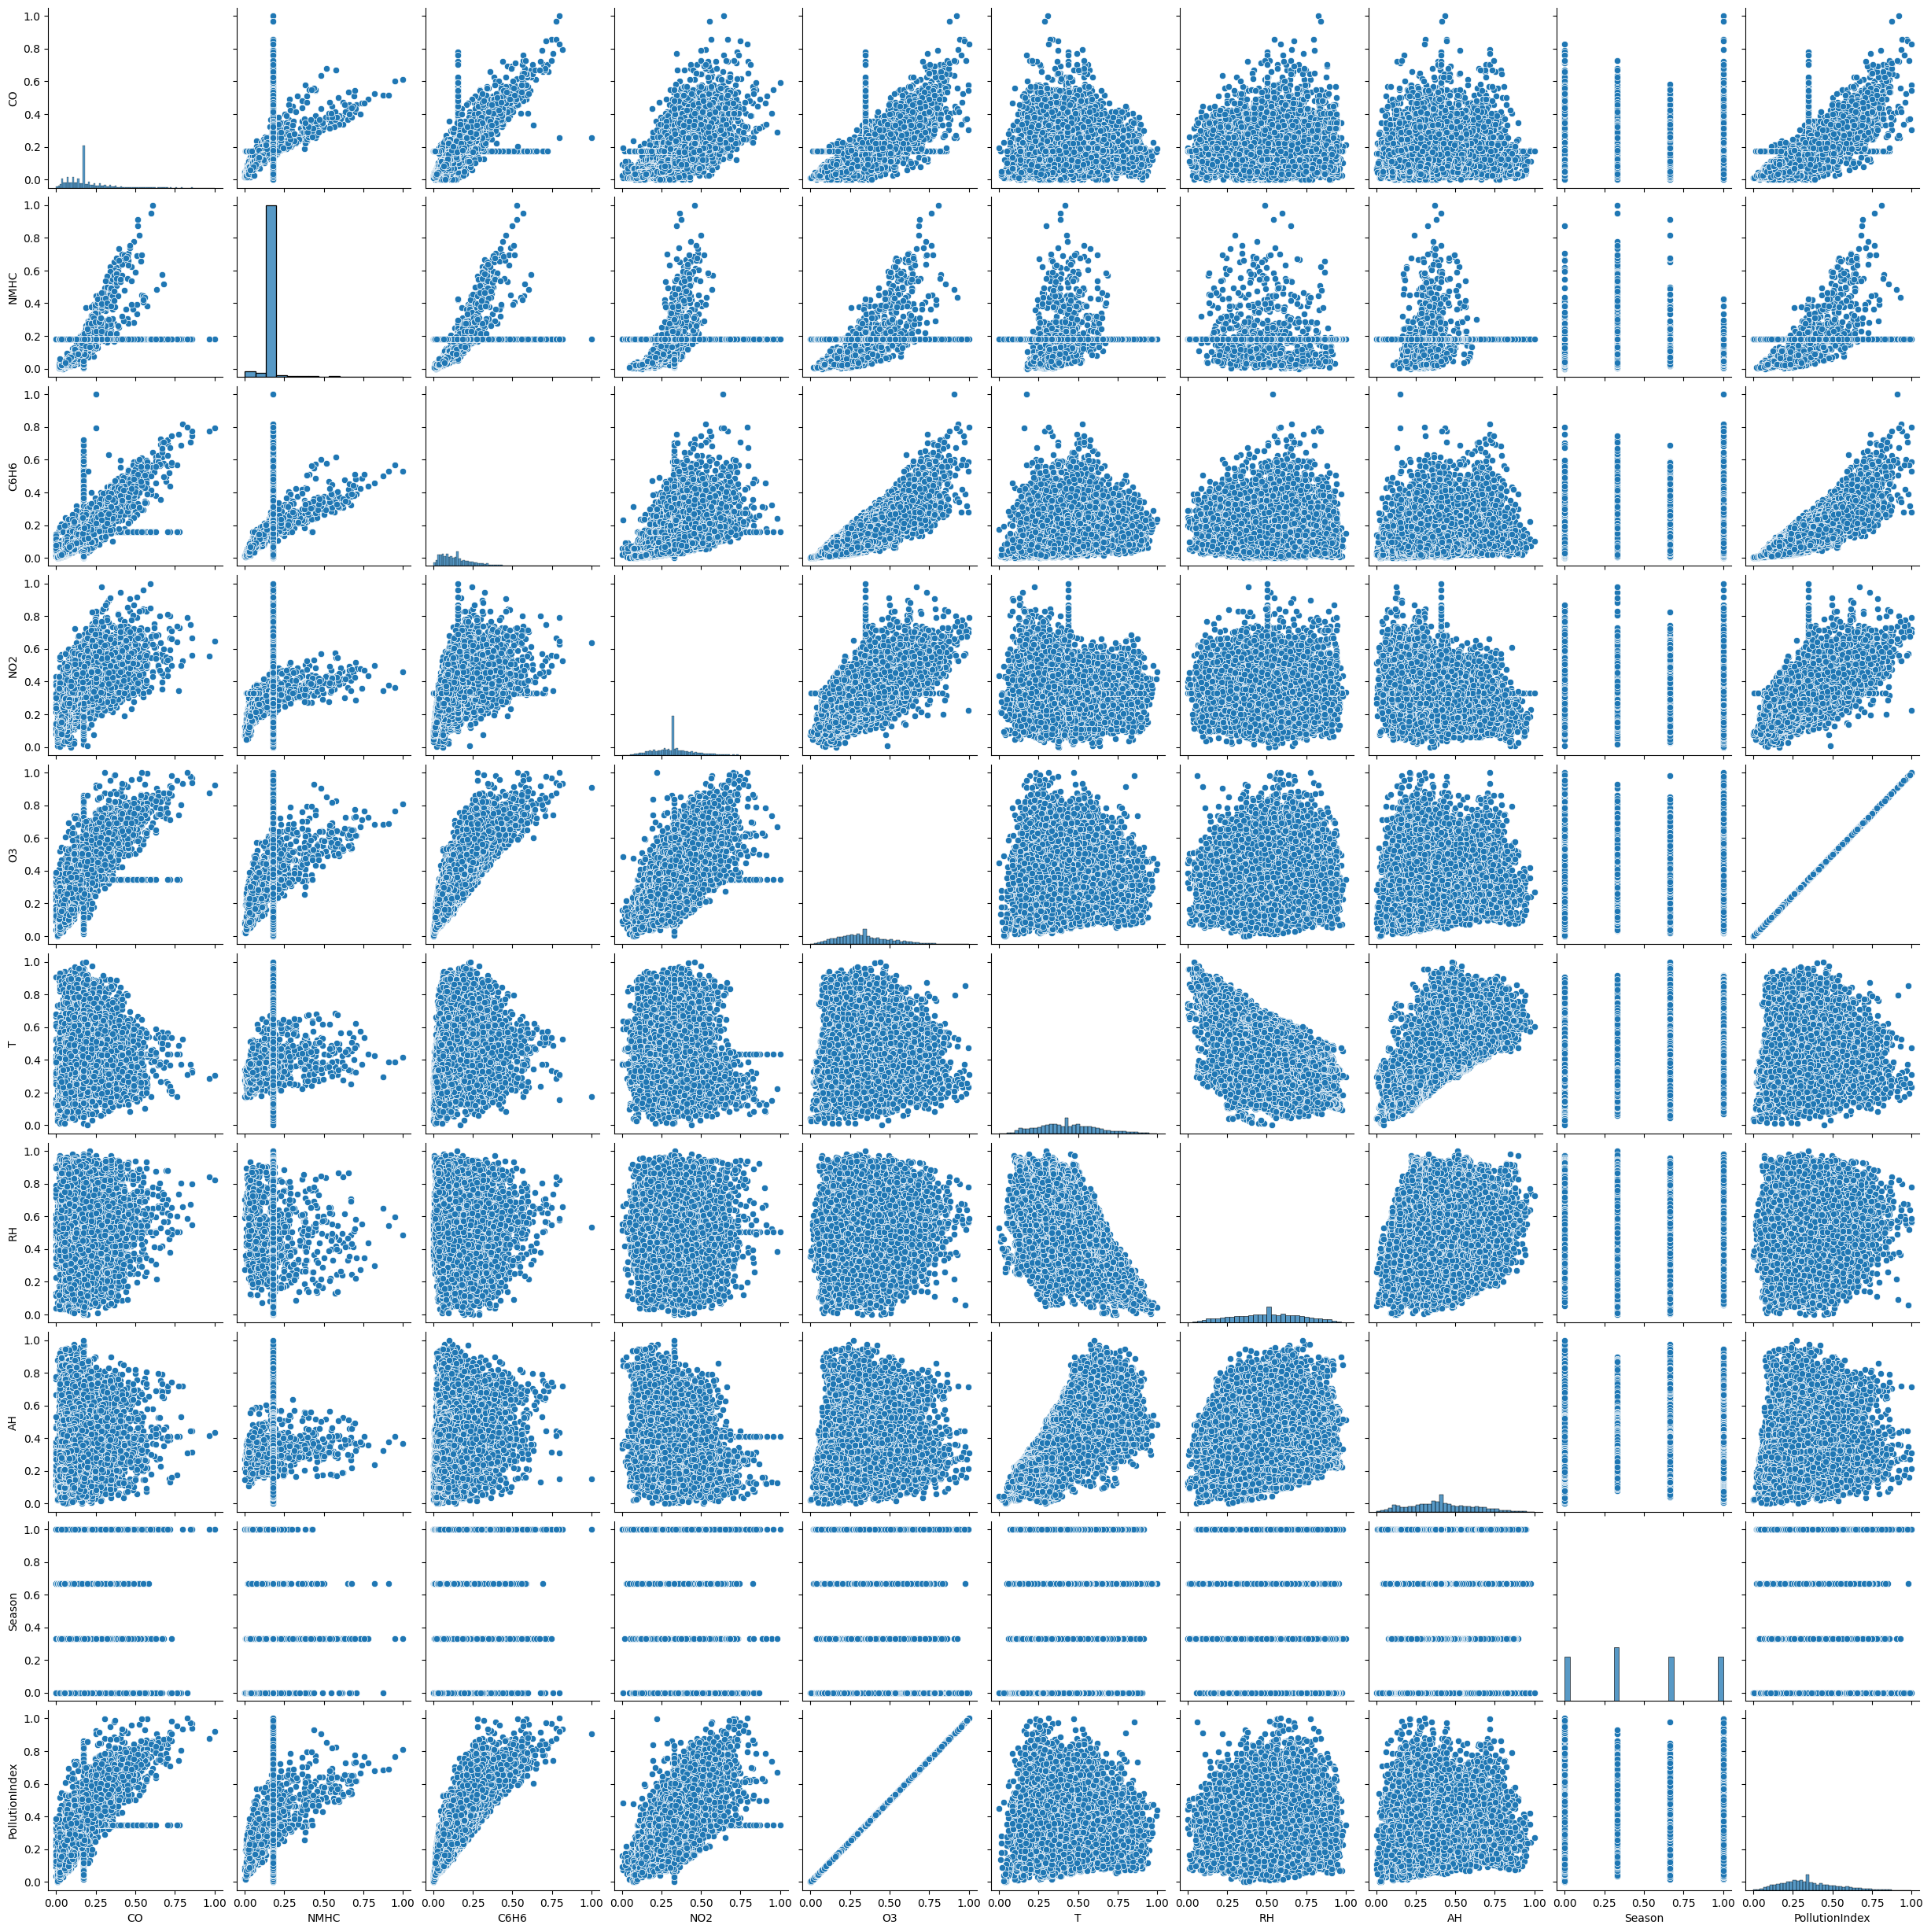

In [ ]:
# 參數兩兩關係圖
from matplotlib import colors
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(['#440154',"#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#['#440154', '#472777', '#475FAA', '#44A6C9', '#41D1D6', '#5DEF70', '#FDE724']
plt.figure()
sns.pairplot(df_air_z,palette= (["#682F2F","#F3AB60"]))
#Taking hue
plt.show()

<ipython-input-75-87ac100f253a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat= df_air_z.corr()


<Axes: >

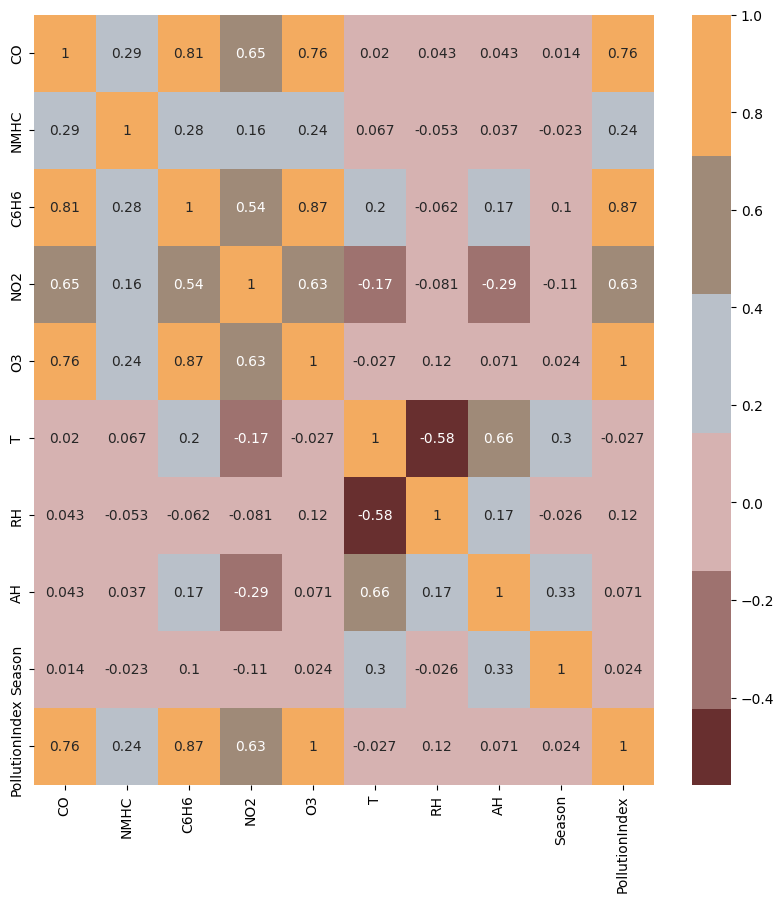

In [ ]:
# 熱像圖
corrmat= df_air_z.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

## 機器學習

In [ ]:
df_air_z.columns

Index(['Date', 'Time', 'CO', 'NMHC', 'C6H6', 'NO2', 'O3', 'T', 'RH', 'AH',
       'Season', 'PollutionIndex'],
      dtype='object')

In [ ]:
# 日期保留月份
df_air_z['Month'] = pd.to_datetime(df_air_z['Date']).dt.month

,Date,Time,CO,NMHC,C6H6,NO2,O3,T,RH,AH,Season,PollutionIndex,Month
0,2004-10-03,18.00.00,0.211864,0.120981,0.185535,0.328402,0.454822,0.333333,0.499371,0.280066,1.000000,0.454822,10
1,2004-10-03,19.00.00,0.161017,0.088832,0.146226,0.266272,0.326238,0.326882,0.484277,0.264282,1.000000,0.326238,10
2,2004-10-03,20.00.00,0.177966,0.068528,0.139937,0.331361,0.370547,0.296774,0.563522,0.276352,1.000000,0.370547,10
3,2004-10-03,21.00.00,0.177966,0.061760,0.143082,0.355030,0.426586,0.277419,0.638994,0.294190,1.000000,0.426586,10
4,2004-10-03,22.00.00,0.127119,0.037225,0.100629,0.337278,0.386186,0.281720,0.633962,0.295216,1.000000,0.386186,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10.00.00,0.254237,0.179198,0.210692,0.556213,0.655083,0.511828,0.252830,0.279578,0.333333,0.655083,4
9353,2005-04-04,11.00.00,0.194915,0.179198,0.177673,0.523669,0.455256,0.563441,0.182390,0.257636,0.333333,0.455256,4
9354,2005-04-04,12.00.00,0.194915,0.179198,0.193396,0.511834,0.378367,0.619355,0.114465,0.222792,0.333333,0.378367,4
9355,2005-04-04,13.00.00,0.169492,0.179198,0.147799,0.455621,0.238488,0.649462,0.054088,0.160876,0.333333,0.238488,4


In [ ]:
df_air_ML = df_air_z.drop(['Date', 'Time', 'Season', 'PollutionIndex'],axis= 1)

,CO,NMHC,C6H6,NO2,O3,T,RH,AH,Month
0,0.211864,0.120981,0.185535,0.328402,0.454822,0.333333,0.499371,0.280066,10
1,0.161017,0.088832,0.146226,0.266272,0.326238,0.326882,0.484277,0.264282,10
2,0.177966,0.068528,0.139937,0.331361,0.370547,0.296774,0.563522,0.276352,10
3,0.177966,0.061760,0.143082,0.355030,0.426586,0.277419,0.638994,0.294190,10
4,0.127119,0.037225,0.100629,0.337278,0.386186,0.281720,0.633962,0.295216,10
...,...,...,...,...,...,...,...,...,...
9352,0.254237,0.179198,0.210692,0.556213,0.655083,0.511828,0.252830,0.279578,4
9353,0.194915,0.179198,0.177673,0.523669,0.455256,0.563441,0.182390,0.257636,4
9354,0.194915,0.179198,0.193396,0.511834,0.378367,0.619355,0.114465,0.222792,4
9355,0.169492,0.179198,0.147799,0.455621,0.238488,0.649462,0.054088,0.160876,4


In [ ]:
# 將資料分成訓練和測試
from sklearn.model_selection import train_test_split
X = df_air_ML.drop(['Month'],axis=1)
Y = df_air_ML['Month']
# 設定種子一樣我們共編比較方便
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, train_size = 0.7, random_state=2023)

In [ ]:
# 類神經網路
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

model_nn1 = MLPClassifier( hidden_layer_sizes = ( 100, 100 ) )
model_nn1.fit( X_train, Y_train )

# 評估模型
Y_predic_nn1 = model_nn1.predict( X_test )
print( classification_report( Y_test, Y_predic_nn1 ) )


              precision    recall  f1-score   support

           1       0.41      0.38      0.39       240
           2       0.41      0.39      0.40       197
           3       0.46      0.58      0.51       365
           4       0.54      0.25      0.34       237
           5       0.34      0.44      0.38       226
           6       0.28      0.35      0.31       225
           7       0.41      0.34      0.37       229
           8       0.38      0.39      0.39       206
           9       0.26      0.20      0.23       208
          10       0.41      0.47      0.44       225
          11       0.43      0.41      0.42       223
          12       0.43      0.43      0.43       227

    accuracy                           0.40      2808
   macro avg       0.40      0.39      0.38      2808
weighted avg       0.40      0.40      0.39      2808



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
SVM 支援向量機模型
from sklearn.svm import SVC

model_svm1 = SVC()

model_svm1.fit( X_test, Y_test )

# 評估模型
Y_predic_svm1 = model_svm1.predict( X_test )

print( classification_report( Y_test, Y_predic_svm1 ) )

              precision    recall  f1-score   support

           1       0.38      0.43      0.41       240
           2       0.44      0.19      0.27       197
           3       0.31      0.68      0.42       365
           4       0.54      0.12      0.20       237
           5       0.32      0.33      0.32       226
           6       0.24      0.25      0.25       225
           7       0.34      0.37      0.35       229
           8       0.40      0.37      0.39       206
           9       0.28      0.12      0.17       208
          10       0.43      0.52      0.47       225
          11       0.52      0.29      0.37       223
          12       0.47      0.38      0.42       227

    accuracy                           0.36      2808
   macro avg       0.39      0.34      0.34      2808
weighted avg       0.38      0.36      0.34      2808



In [ ]:
# KNN 分類模型
from sklearn.neighbors import KNeighborsClassifier

model_knn1 = KNeighborsClassifier( n_neighbors = 20 )
model_knn1.fit( X_train, Y_train )

Y_predic_knn1 = model_knn1.predict( X_test )

print( classification_report( Y_test, Y_predic_knn1 ) )

              precision    recall  f1-score   support

           1       0.45      0.47      0.46       240
           2       0.40      0.43      0.41       197
           3       0.43      0.57      0.49       365
           4       0.39      0.38      0.38       237
           5       0.41      0.42      0.41       226
           6       0.34      0.43      0.38       225
           7       0.46      0.36      0.41       229
           8       0.41      0.45      0.43       206
           9       0.33      0.22      0.27       208
          10       0.46      0.53      0.49       225
          11       0.52      0.38      0.44       223
          12       0.57      0.37      0.45       227

    accuracy                           0.43      2808
   macro avg       0.43      0.42      0.42      2808
weighted avg       0.43      0.43      0.42      2808



In [ ]:
# 決策樹模型
from sklearn.tree import DecisionTreeClassifier

model_tree1 = DecisionTreeClassifier( max_depth = 9 )

model_tree1.fit( X_train, Y_train )
Y_predic_tree1 = model_tree1.predict( X_test )

print( classification_report( Y_test, Y_predic_tree1 ) )

              precision    recall  f1-score   support

           1       0.39      0.40      0.39       240
           2       0.33      0.38      0.35       197
           3       0.39      0.50      0.44       365
           4       0.38      0.39      0.38       237
           5       0.38      0.37      0.37       226
           6       0.28      0.44      0.35       225
           7       0.40      0.34      0.37       229
           8       0.48      0.44      0.46       206
           9       0.31      0.20      0.24       208
          10       0.56      0.38      0.45       225
          11       0.45      0.35      0.39       223
          12       0.44      0.37      0.40       227

    accuracy                           0.39      2808
   macro avg       0.40      0.38      0.38      2808
weighted avg       0.40      0.39      0.39      2808



In [ ]:
簡單貝氏分類模型
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()
model_nb.fit( X_train, Y_train )

# 評估模型
Y_predic_nb = model_nb.predict( X_test )
print( classification_report( Y_test, Y_predic_nb ) )

              precision    recall  f1-score   support

           1       0.32      0.38      0.35       240
           2       0.36      0.11      0.16       197
           3       0.40      0.22      0.28       365
           4       0.53      0.13      0.21       237
           5       0.21      0.38      0.27       226
           6       0.00      0.00      0.00       225
           7       0.23      0.45      0.30       229
           8       0.31      0.21      0.25       206
           9       0.14      0.11      0.12       208
          10       0.24      0.61      0.35       225
          11       0.23      0.25      0.24       223
          12       0.27      0.27      0.27       227

    accuracy                           0.26      2808
   macro avg       0.27      0.26      0.23      2808
weighted avg       0.28      0.26      0.24      2808



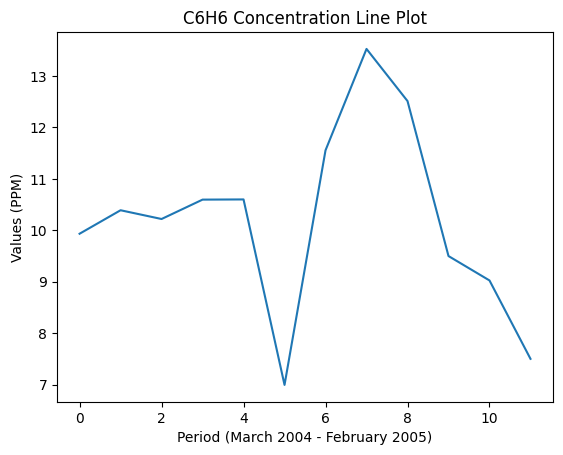

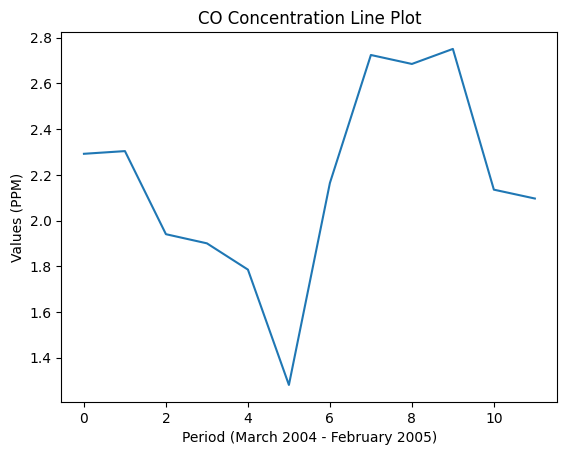

In [ ]:
#co,c6h6,no2的濃度變化


import pandas as pd
import requests
import zipfile
import io
import matplotlib.pyplot as plt
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
response = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall()
df_aql = pd.read_csv("AirQualityUCI.csv", sep=";")

#co與c6h6的濃度變化

pollutants = {
    'C6H6': 'C6H6(GT)',
    'CO': 'CO(GT)'
}

months = ['03/2004', '04/2004', '05/2004', '06/2004', '07/2004', '08/2004',
          '09/2004', '10/2004', '11/2004', '12/2004', '01/2005', '02/2005']

for pollutant, column in pollutants.items():
    mean_values = []
    for month in months:
        data = df_aql[df_aql['Date'].str[3:] == month][column]
        data = pd.to_numeric(data.str.replace(',', '.'), errors='coerce')
        data = data[data != -200]
        mean_values.append(data.mean())

    df = pd.DataFrame(mean_values, columns=['Values'])

    plt.plot(df.index, df['Values'])
    plt.xlabel('Period (March 2004 - February 2005)')
    plt.ylabel('Values (PPM)')
    plt.title(f'{pollutant} Concentration Line Plot')
    plt.show()


一氧化碳(CO)
來源
人為造成的一氧化碳主要來自於人為森林大火、焚燒作物、汽車、燃燒化石燃料。

潛在危險性
吸入人體的一氧化碳會和氧氣競爭與血紅素結合，造成血紅素無法提供足夠氧氣給身體組織，即一氧化碳中毒。暴露在一定濃度一氧化碳環境中可能造成頭暈、疲憊、頭痛，高濃度甚至會引發昏迷、死亡。



一氧化碳(CO) 來源 人為造成的一氧化碳主要來自於人為森林大火、焚燒作物、汽車、燃燒化石燃料。

潛在危險性 吸入人體的一氧化碳會和氧氣競爭與血紅素結合，造成血紅素無法提供足夠氧氣給身體組織，即一氧化碳中毒。暴露在一定濃度一氧化碳環境中可能造成頭暈、疲憊、頭痛，高濃度甚至會引發昏迷、死亡。

苯(Benzene, C6H6) 來源 苯是石油化工的一種基本原料，為廣泛使用的工業化學物質，例如塑膠、人工樹脂、尼龍及其他人造纖維的工廠，苯也用來製造潤滑油、染劑、洗滌劑、藥物，以及殺蟲劑。

潛在危險性 空氣中的苯會吸附於雨水或雪，再降落到地表。 苯在水中及土壤的分解速度較緩慢，且可穿過土壤到達地下水層。 苯具有高毒性，且是一種致癌物質。對血液影響甚劇，苯會危害骨髓、使紅血球的數目降低而導致貧血，也會造成出血不止、影響免疫系統而增加受到感染的機會。

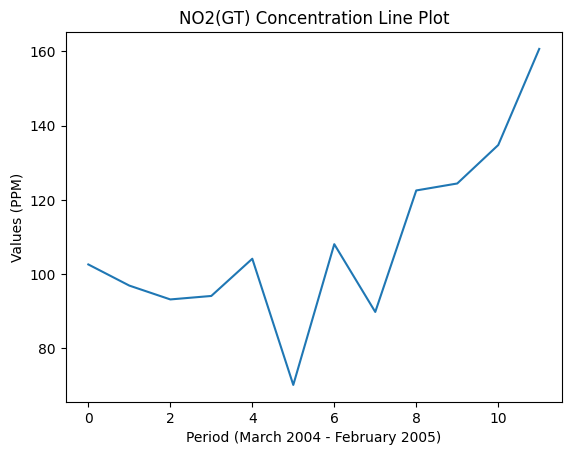

In [ ]:
#NO2(GT)
mean_values = []
for month in months:
    data = df_aql[df_aql['Date'].str[3:] == month]['NO2(GT)']
    data = data[data != -200]
    mean_values.append(data.mean())

df = pd.DataFrame(mean_values, columns=['Values'])

plt.plot(df.index, df['Values'])
plt.xlabel('Period (March 2004 - February 2005)')
plt.ylabel('Values (PPM)')
plt.title('NO2(GT) Concentration Line Plot')
plt.show()

二氧化氮(NO2)
來源
空氣中的二氧化氮可由大多數燃燒過程生成。在高溫下，氮氣與氧氣結合而產生二氧化氮。(火力發電廠)

潛在危險性
二氧化氮是一種影響空氣品質的重要污染物。雖然吸入二氧化氮會導致中毒反應，但由於二氧化氮對人體過於刺激反而使得中毒事故較容易避免。